__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [2]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

#import seaborn as sns
#from presentation_sns_config import *

from experiment_params import *
from cost_funcs import *
from fl_sim_client import *
from fl_sim_server import *
import time
import pickle
from sklearn.decomposition import PCA

In [3]:
path = r'C:\Users\kdmen\Desktop\Research\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Verify Federated Set Up Runs

In [4]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [5]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# No-FL Case
## Random Inits

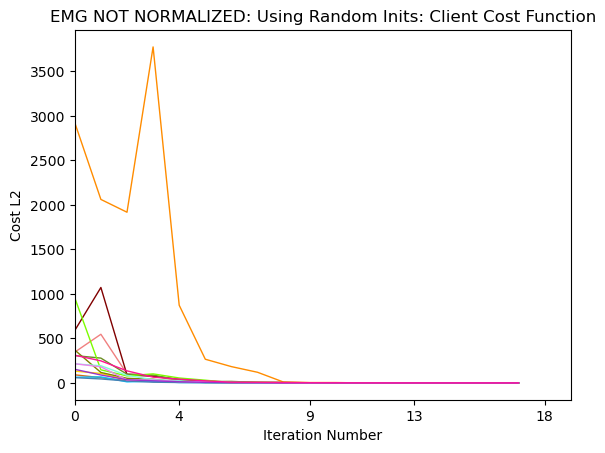

In [6]:
user_nofl_rand_init = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_nofl_rand_init = Server(-1, D_0, 'NoFL', user_nofl_rand_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_nofl_rand_init.execute_FL_loop()
    
condensed_external_plotting(user_nofl_rand_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='EMG NOT NORMALIZED: Using Random Inits: Client Cost Function')

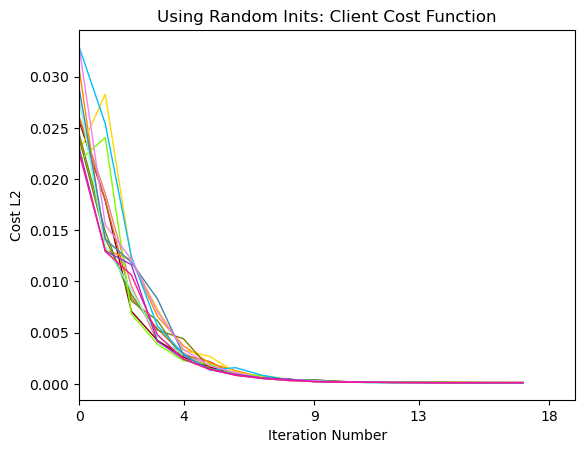

In [7]:
user_nofl_rand_init = [Client(i, D_0, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_nofl_rand_init = Server(-1, D_0, 'NoFL', user_nofl_rand_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_nofl_rand_init.execute_FL_loop()
    
condensed_external_plotting(user_nofl_rand_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using Random Inits: Client Cost Function')

## CPHS Inits

In [8]:
avg_cond0_init = cond0_init_decs[0]
for i in range(1, 14):
    avg_cond0_init += cond0_init_decs[i]
avg_cond0_init /= 14

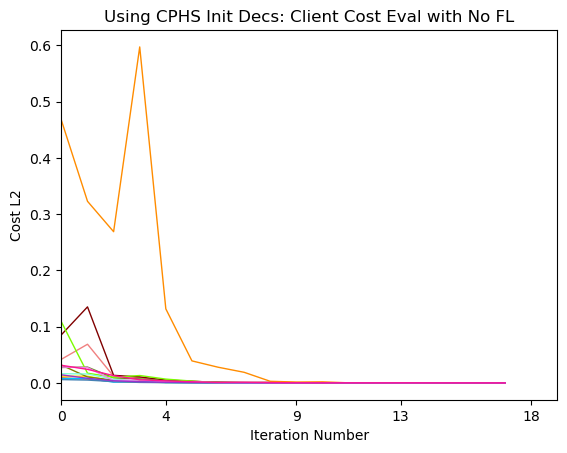

In [9]:
user_c0_no_fl_w_cphs_init = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_w_cphs_init = Server(-1, avg_cond0_init, 'NoFL', user_c0_no_fl_w_cphs_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_w_cphs_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

## Using Final Client Decs as Client Inits

In [10]:
avg_client_init = user_c0_no_fl_w_cphs_init[0].w
for i in range(1, 14):
    avg_client_init += user_c0_no_fl_w_cphs_init[i].w
avg_client_init /= 14

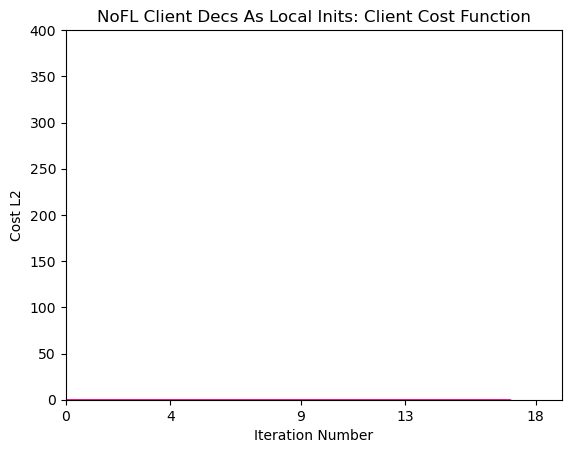

In [11]:
user_c0_no_fl_wclient_init = [Client(i, user_c0_no_fl_w_cphs_init[i].w, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, set_alphaF_zero=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_wclient_init = Server(-1, avg_client_init, 'NoFL', user_c0_no_fl_wclient_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_no_fl_wclient_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, ylim_max=400, custom_title='NoFL Client Decs As Local Inits: Client Cost Function')

In [12]:
user_c0_no_fl_wclient_init[0].local_error_log

[0.000119,
 8.99e-05,
 8.6e-05,
 7.32e-05,
 9.8e-05,
 9.33e-05,
 0.0001264,
 7.89e-05,
 9.92e-05,
 0.0001454,
 9.65e-05,
 9.83e-05,
 0.0001211,
 0.000106,
 8.95e-05,
 5.96e-05,
 8.01e-05,
 5.53e-05]

How is the training error zero... I guess I should add a test run and be plotting test error...

# Federated Learning
## 1 Scipy Step, 500 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 182, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 324, 50)



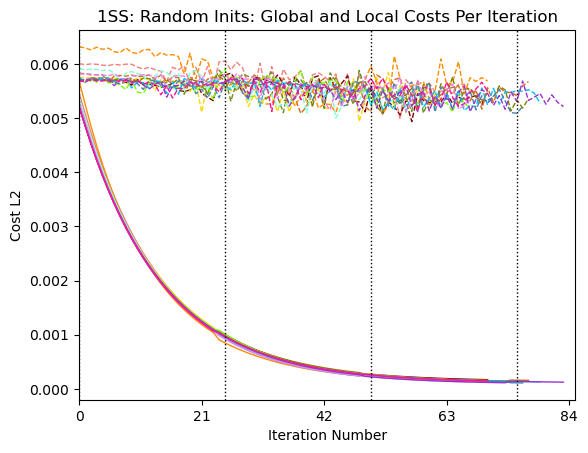

In [31]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1SS: Random Inits: Global and Local Costs Per Iteration')

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 170, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 357, 50)



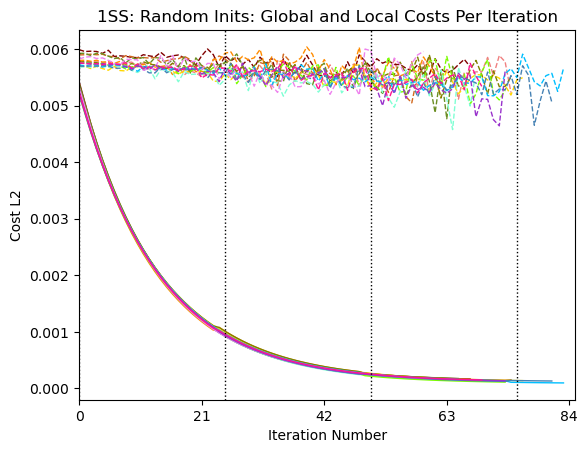

In [32]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=10, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1SS: Random Inits: Global and Local Costs Per Iteration')

In [33]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'global', custom_title='1SS: Random Inits: Global and Local Costs Per Iteration')

Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 124, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 274, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 455, 75)



AttributeError: 'list' object has no attribute 'all_clients'

In [ ]:
## FOR POSTER PLOTTING

# Take average of user error logs
# Plot wrt local round
# Plot wrt global round

In [ ]:
input_data
version
exclusion_ID_lst=[]
dim_reduc_factor=1
plot_gradient=False
plot_pers_gradient=False
plot_this_ID_only=-1
plot_global_gradient=False
global_error=True
local_error=True
pers_error=False
different_local_round_thresh_per_client=False
legend_on=False
plot_performance=False
plot_Dnorm=False
plot_Fnorm=False
num_participants=14
show_update_change=True
custom_title=""
axes_off_list=[]
ylim_max=None
ylim_min=None
my_legend_loc='best'
global_alpha=1
local_alpha=1
pers_alpha=1
global_linewidth=1
local_linewidth=1
pers_linewidth=1
global_linestyle='dashed'
local_linestyle='solid'
pers_linestyle='dotted'):


In [ ]:
#def condensed_external_plotting(input_data, version, exclusion_ID_lst=[], dim_reduc_factor=1, plot_gradient=False, plot_pers_gradient=False, plot_this_ID_only=-1, plot_global_gradient=False, global_error=True, local_error=True, pers_error=False, different_local_round_thresh_per_client=False, legend_on=False, plot_performance=False, plot_Dnorm=False, plot_Fnorm=False, num_participants=14, show_update_change=True, custom_title="", axes_off_list=[], ylim_max=None, ylim_min=None, my_legend_loc='best', global_alpha=1, local_alpha=1, pers_alpha=1, global_linewidth=1, local_linewidth=1, pers_linewidth=1, global_linestyle='dashed', local_linestyle='solid', pers_linestyle='dotted'):
    
    id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
    
    def moving_average(numbers, window_size):
        i = 0
        moving_averages = []
        while i < len(numbers) - window_size + 1:
            this_window = numbers[i : i + window_size]

            window_average = sum(this_window) / window_size
            moving_averages.append(window_average)
            i += window_size
        return moving_averages
    
    if custom_title:
        my_title = custom_title
    elif global_error and local_error:
        my_title = f'Global and Local Costs Per {version.title()} Iter'
    elif global_error:
        my_title = f'Global Cost Per {version.title()} Iter'
    elif local_error:
        my_title = f'Local Costs Per {version.title()} Iter'
    else:
        raise ValueError("You set both global and local to False.  At least one must be true in order to plot something.")

    # Determine if this is global or local, based on the input for now... could probably add a flag but meh
    if version.upper()=='LOCAL':
        user_database = input_data
    elif version.upper()=='GLOBAL':
        user_database = input_data.all_clients
    else:
        raise ValueError("log_type must be either global or local, please retry")
        
    max_local_iters = 0

    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue 
        elif plot_this_ID_only!=-1 and i!=plot_this_ID_only:
            continue
        elif len(user_database[i].local_error_log)<2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue 
        else: 
            # This is used for plotting later
            if len(user_database[i].local_error_log) > max_local_iters:
                max_local_iters = len(user_database[i].local_error_log)

            if version.upper()=='LOCAL':
                if global_error:
                    df = pd.DataFrame(user_database[i].global_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha, linestyle=global_linestyle)
                if local_error:
                    df = pd.DataFrame(user_database[i].local_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=local_linewidth, alpha=local_alpha, linestyle=local_linestyle)
                if pers_error:
                    df = pd.DataFrame(user_database[i].pers_error_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, alpha=pers_alpha, linestyle=pers_linestyle)
                # NOT THE COST FUNC, THESE ARE THE INDIVIDUAL COMPONENTS OF IT
                if plot_performance:
                    df = pd.DataFrame(user_database[i].performance_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, label=f"User{user_database[i].ID} Performance")
                if plot_Dnorm:
                    df = pd.DataFrame(user_database[i].Dnorm_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle="--", label=f"User{user_database[i].ID} Dnorm")
                if plot_Fnorm:
                    df = pd.DataFrame(user_database[i].Fnorm_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=pers_linewidth, linestyle=":", label=f"User{user_database[i].ID} Fnorm")
                if plot_gradient:
                    df = pd.DataFrame(user_database[i].gradient_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=2, label=f"User{user_database[i].ID} Local Gradient")
                if plot_pers_gradient:
                    df = pd.DataFrame(user_database[i].pers_gradient_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=2, label=f"User{user_database[i].ID} Pers Gradient")
                if plot_global_gradient:
                    df = pd.DataFrame(user_database[i].global_gradient_log)
                    df.reset_index(inplace=True)
                    df10 = df.groupby(df.index//dim_reduc_factor, axis=0).mean()
                    plt.plot(df10.values[:, 0], df10.values[:, 1], color=id2color[user_database[i].ID], linewidth=2, label=f"User{user_database[i].ID} Global Gradient")
            elif version.upper()=='GLOBAL':
                if plot_Fnorm or plot_Dnorm or plot_performance:
                    print("Fnorm, Dnorm, and performance are currently not supported for version==GLOBAL")
                    
                if global_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.global_error_log[j][i][2])
                        # This is actually the client local round
                        client_global_round.append(input_data.global_error_log[j][i][1])
                    # Why is the [1:] here?  What happens when dim_reduc=1? 
                    # Verify that this is the same as my envelope code...
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=global_linewidth, alpha=global_alpha, linestyle=global_linestyle)

                if local_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.local_error_log[j][i][2])
                        client_global_round.append(input_data.local_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=local_linewidth, alpha=local_alpha, linestyle=local_linestyle)
               
                if pers_error:
                    client_loss = []
                    client_global_round = []
                    for j in range(input_data.current_round):
                        client_loss.append(input_data.pers_error_log[j][i][2])
                        client_global_round.append(input_data.pers_error_log[j][i][1])
                    plt.plot(moving_average(client_global_round, dim_reduc_factor)[1:], moving_average(client_loss, dim_reduc_factor)[1:], color=id2color[user_database[i].ID], linewidth=pers_linewidth, alpha=pers_alpha, linestyle=pers_linestyle)

                if show_update_change:
                    for update_round in user_database[i].update_transition_log:
                        plt.axvline(x=(update_round), color=id2color[user_database[i].ID], linewidth=0.5, alpha=0.6)  

    if version.upper()=='LOCAL' and show_update_change==True:
        for i in range(max_local_iters):
            if i%user_database[0].local_round_threshold==0:
                plt.axvline(x=i, color="k", linewidth=1, linestyle=':')
                
    if axes_off_list!=[]:
        ax = plt.gca()
        for my_axis in axes_off_list:
            ax.spines[my_axis].set_visible(False)
              
    plt.ylabel('Cost L2')
    plt.xlabel('Iteration Number')
    plt.title(my_title)
    if version.upper()=='GLOBAL':
        max_local_iters = input_data.current_round
    else:
        num_ticks = 5
        plt.xticks(ticks=np.linspace(0,max_local_iters,num_ticks,dtype=int))
        plt.xlim((0,max_local_iters+1))
    if ylim_max!=None:
        if ylim_min!=None:
            plt.ylim((ylim_min,ylim_max))
        else:
            plt.ylim((0,ylim_max))
    if legend_on:
        plt.legend(loc=my_legend_loc)
    plt.show()

In [29]:
# TRAINING LOSS
#self.local_error_log = []
#self.global_error_log = []
#self.pers_error_log = []
# TESTING LOSS
#self.local_test_error_log = []
#self.global_test_error_log = []
#self.pers_test_error_log = []
#all_user_input = [user.global_test_error_log for user in user_c0_1ScipyStep]
all_user_input = user_c0_1ScipyStep

highlight_default=False
default_local=False
default_global=False
default_pers=False
plot_mean=True
plot_median=False
exclusion_ID_lst=[]
dim_reduc_factor=1
plot_gradient=False
plot_pers_gradient=False
plot_this_ID_only=-1
plot_global_gradient=False
global_error=True
local_error=True
pers_error=False
different_local_round_thresh_per_client=False
legend_on=True
num_participants=14
show_update_change=True
custom_title=""
axes_off_list=[]
xlim_max=None
xlim_min=None
ylim_max=None
ylim_min=None
input_linewidth=1
my_legend_loc='best'
iterable_labels=[]
iterable_colors=[]


#my_label
my_title = 'Test run'


I was using central_tendency_plotting() instead of condensed_external_plotting, which is why all_user_input was being weird

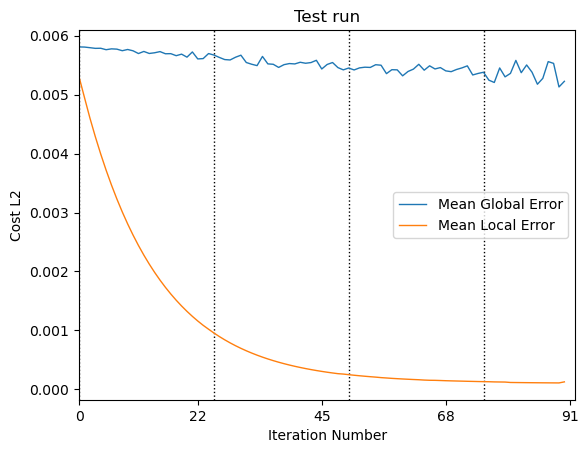

In [30]:
#def central_tendency_plotting(all_user_input, highlight_default=False, default_local=False, default_global=False, default_pers=False, plot_mean=True, plot_median=False, exclusion_ID_lst=[], dim_reduc_factor=1, plot_gradient=False, plot_pers_gradient=False, plot_this_ID_only=-1, plot_global_gradient=False, global_error=True, local_error=True, pers_error=False, different_local_round_thresh_per_client=False, legend_on=True, plot_performance=False, plot_Dnorm=False, plot_Fnorm=False, num_participants=14, show_update_change=True, custom_title="", axes_off_list=[], xlim_max=None, xlim_min=None, ylim_max=None, ylim_min=None, input_linewidth=1, my_legend_loc='best', iterable_labels=[], iterable_colors=[]):

id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
        7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...

if dim_reduc_factor!=1:
    raise("dim_reduc_factor MUST EQUAL 1!")

global_df = pd.DataFrame()
local_df = pd.DataFrame()
pers_df = pd.DataFrame()
#grad_df = pd.DataFrame()
#pers_grad_df = pd.DataFrame()
#global_grad_df = pd.DataFrame()

#param_list = [plot_gradient, plot_pers_gradient, plot_global_gradient, global_error, local_error, pers_error, plot_performance, plot_Dnorm, plot_Fnorm]
param_list = [False, False, False, global_error, local_error, False, False, False, False]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Error', 4:'Local Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += window_size
    return moving_averages


max_local_iters = 0
label_idx = 0
for user_idx, user_database in enumerate(all_user_input):
    #if True:
    #    user_database = all_user_input
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue 
        elif len(user_database[i].local_error_log)<2:
            # This node never trained so just skip it so it doesn't break the plotting
            print(f"USER {user_idx} NEVER GOT TRAINED, SKIPPING")
            continue 
        else: 
            # This is used for plotting later
            if len(user_database[i].local_error_log) > max_local_iters:
                max_local_iters = len(user_database[i].local_error_log)

            if global_error or (user_idx==0 and default_global==True):
                df = pd.DataFrame(user_database[i].global_error_log)
                global_df = pd.concat([global_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            if local_error or (user_idx==0 and default_local==True):
                df = pd.DataFrame(user_database[i].local_error_log)
                local_df = pd.concat([local_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            #if pers_error or (user_idx==0 and default_pers==True):
            #    df = pd.DataFrame(user_database[i].pers_error_log)
            #    pers_df = pd.concat([pers_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            #if plot_gradient:
            #    df = pd.DataFrame(user_database[i].gradient_log)
            #    grad_df = pd.concat([grad_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            #if plot_pers_gradient:
            #    df = pd.DataFrame(user_database[i].pers_gradient_log)
            #    pers_grad_df = pd.concat([pers_grad_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            #if plot_global_gradient:
            #    df = pd.DataFrame(user_database[i].global_gradient_log)
            #    global_grad_df = pd.concat([global_grad_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])

    # Bad temporary soln for MVP
    #all_dfs_dict = {0:grad_df.reset_index(drop=True), 1:pers_grad_df.reset_index(drop=True), 2:global_grad_df.reset_index(drop=True), 3:global_df.reset_index(drop=True), 4:local_df.reset_index(drop=True), 5:pers_df.reset_index(drop=True), 6:perf_df.reset_index(drop=True), 7:dnorm_df.reset_index(drop=True), 8:fnorm_df.reset_index(drop=True)}
    all_dfs_dict = {0:0, 1:1, 2:2, 3:global_df.reset_index(drop=True), 4:local_df.reset_index(drop=True), 5:pers_df.reset_index(drop=True), 6:6, 7:7, 8:8}

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()

    if show_update_change==True:
            for i in range(max_local_iters):
                if i%user_database[0].local_round_threshold==0:
                    plt.axvline(x=i, color="k", linewidth=1, linestyle=':') 

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean==True and vec_idx==0) or (plot_median==True and vec_idx==1):
                    if iterable_labels!=[]:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    if "GLOBAL:" in my_label.upper():
                        my_linestyle = 'dashed'
                    elif "LOCAL:" in my_label.upper():
                        my_linestyle = 'solid'
                    elif "PERS:" in my_label.upper():
                        my_linestyle = 'dotted'
                    else:
                        my_linestyle = 'solid'
                    my_alpha = 0.4 if (highlight_default and user_idx==0) else 1
                    my_linewidth = 5 if (highlight_default and user_idx==0) else input_linewidth
                    plt.plot(range(len(vec_vec)), vec_vec, label=my_label, alpha=my_alpha, linewidth=my_linewidth, linestyle=my_linestyle)


    #param_list FOR REFERENCE: [plot_gradient, plot_pers_gradient, plot_global_gradient, global_error, local_error, pers_error, plot_performance, plot_Dnorm, plot_Fnorm]         
    if user_idx==0:
        if default_global:  # 3 corresponds to global
            global_idx = 3
            all_vecs_dict[global_idx][0] = all_dfs_dict[global_idx].mean()
            all_vecs_dict[global_idx][1] = all_dfs_dict[global_idx].median()
            my_vec = all_vecs_dict[global_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean==True and vec_idx==0) or (plot_median==True and vec_idx==1):
                    my_label = f"{tendency_label_dict[vec_idx]} Global Error"
                    my_alpha = 0.4 if (highlight_default and user_idx==0) else 1
                    my_linewidth = 5 if (highlight_default and user_idx==0) else input_linewidth
                    plt.plot(range(len(vec_vec)), vec_vec, label=my_label, alpha=my_alpha, linewidth=my_linewidth)
        if default_local:  # 4 corresponds to local
            local_idx = 4
            all_vecs_dict[local_idx][0] = all_dfs_dict[local_idx].mean()
            all_vecs_dict[local_idx][1] = all_dfs_dict[local_idx].median()
            my_vec = all_vecs_dict[local_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean==True and vec_idx==0) or (plot_median==True and vec_idx==1):
                    my_label = f"{tendency_label_dict[vec_idx]} Local Error"
                    my_alpha = 0.4 if (highlight_default and user_idx==0) else 1
                    my_linewidth = 5 if (highlight_default and user_idx==0) else input_linewidth
                    plt.plot(range(len(vec_vec)), vec_vec, label=my_label, alpha=my_alpha, linewidth=my_linewidth)
        if default_pers:  # 5 corresponds to pers
            pers_idx = 5
            all_vecs_dict[pers_idx][0] = all_dfs_dict[pers_idx].mean()
            all_vecs_dict[pers_idx][1] = all_dfs_dict[pers_idx].median()
            my_vec = all_vecs_dict[pers_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean==True and vec_idx==0) or (plot_median==True and vec_idx==1):
                    my_label = f"{tendency_label_dict[vec_idx]} Personalized Error"
                    my_alpha = 0.4 if (highlight_default and user_idx==0) else 1
                    my_linewidth = 5 if (highlight_default and user_idx==0) else input_linewidth
                    plt.plot(range(len(vec_vec)), vec_vec, label=my_label, alpha=my_alpha, linewidth=my_linewidth)

plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title(my_title)
num_ticks = 5
plt.xticks(ticks=np.linspace(0,max_local_iters,num_ticks,dtype=int))
plt.xlim((0,max_local_iters+1))

if ylim_max!=None:
    if ylim_min!=None:
        plt.ylim((ylim_min,ylim_max))
    else:
        plt.ylim((0,ylim_max))
if xlim_max!=None:
    if xlim_min!=None:
        plt.xlim((xlim_min,xlim_max))
    else:
        plt.xlim((0,xlim_max))

if legend_on:
    plt.legend(loc=my_legend_loc)

if axes_off_list!=[]:
    # left bottom top right 1 1 1 1
    ax = plt.gca()
    for key_pair in axes_off_list:
        ax.spines[key_pair[0]].set_visible(key_pair[1])

plt.show()

In [14]:
#condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

## Using Final Client Decs as Local Inits
> Local error log is all 0s for some reason.......

Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 181, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 321, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 473, 75)



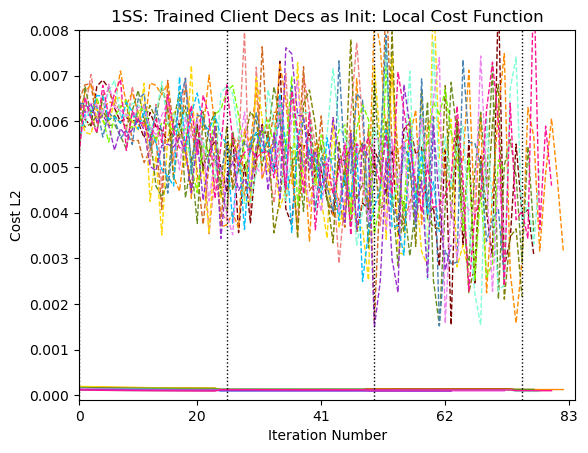

In [15]:
user_c0_1ScipyStep_wclient_init = [Client(i, user_c0_1ScipyStep[i].w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wclient_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wclient_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wclient_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wclient_init, 'local', ylim_min=-0.0001, ylim_max=0.008, custom_title='1SS: Trained Client Decs as Init: Local Cost Function')

## Using Final Global Model as Client Init for All

Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 132, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 301, 50)



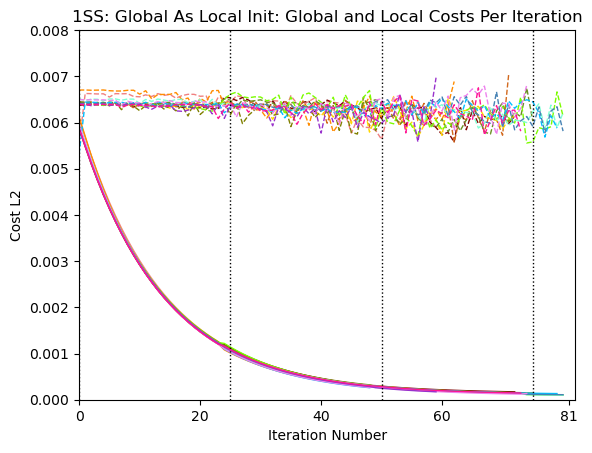

In [16]:
user_c0_1ScipyStep_wglobal_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobal_init = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_wglobal_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wglobal_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobal_init, 'local', ylim_max=0.008, custom_title='1SS: Global As Local Init: Global and Local Costs Per Iteration')

## Using Final Global Model as Both Init for All
> Global model also set to prev final global

Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 228, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 391, 50)



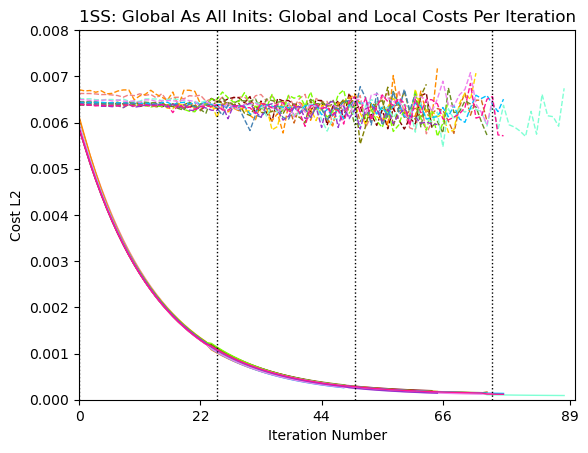

In [17]:
user_c0_1ScipyStep_wglobalx2_init = [Client(i, global_model_1scipystep.w, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_wglobalx2_init = Server(1, global_model_1scipystep.w, 'FedAvg', user_c0_1ScipyStep_wglobalx2_init)

for i in range(big_loop_iters):
    global_model_1scipystep_wglobalx2_init.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep_wglobalx2_init, 'local', ylim_max=0.008, custom_title='1SS: Global As All Inits: Global and Local Costs Per Iteration')

# Aggregated NoFL Plot

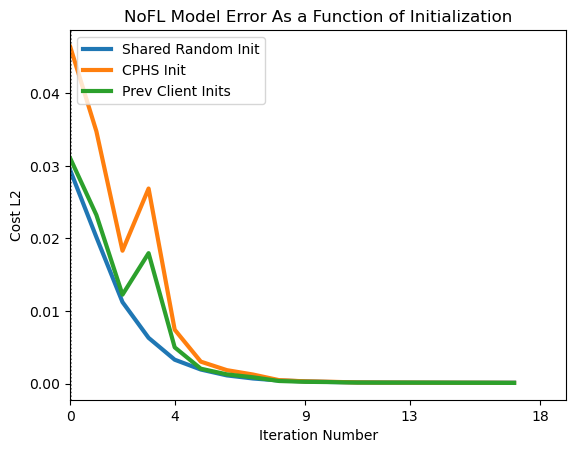

In [18]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='NoFL Model Error As a Function of Initialization')

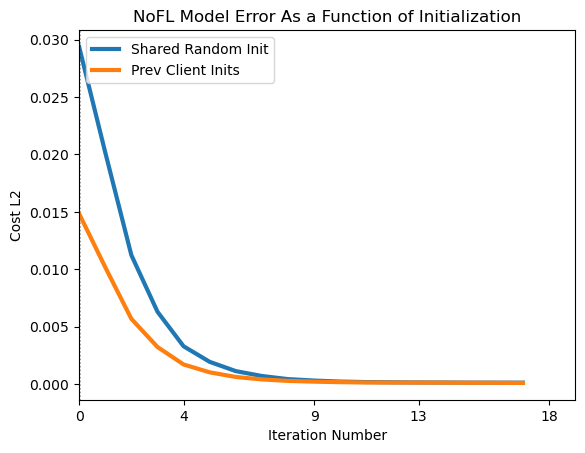

In [19]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='NoFL Model Error As a Function of Initialization')

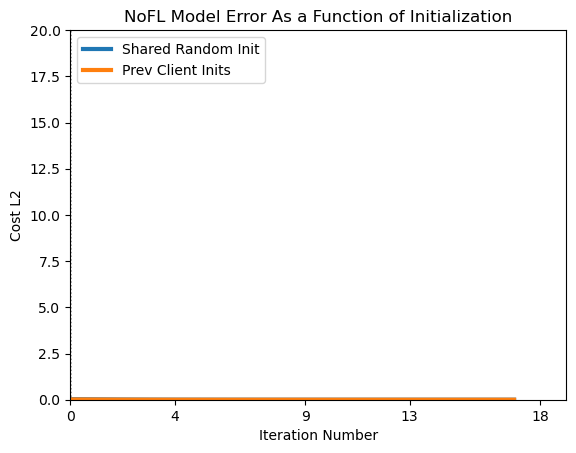

In [20]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'Prev Client Inits'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, ylim_min=0, ylim_max=20, custom_title='NoFL Model Error As a Function of Initialization')

# Aggregated FL Plot

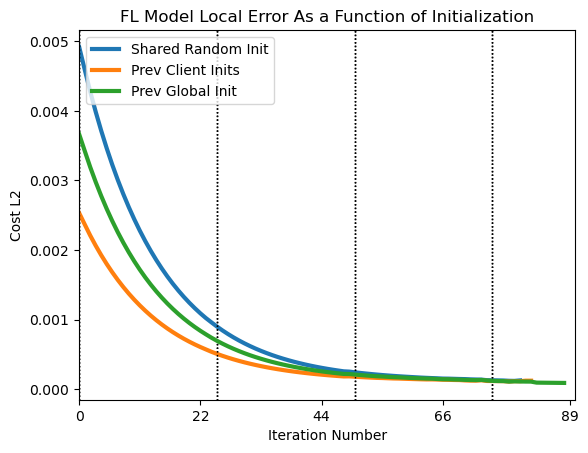

In [21]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Shared Random Init', 'Prev Client Inits', 'Prev Global Init'], input_linewidth=3, my_legend_loc='upper left', local_error=True, global_error=False, custom_title='FL Model Local Error As a Function of Initialization')

In [1]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, my_legend_loc='center', local_error=True, global_error=True, custom_title='FL Model Error As a Function of Initialization Matrix')

NameError: name 'central_tendency_plotting' is not defined

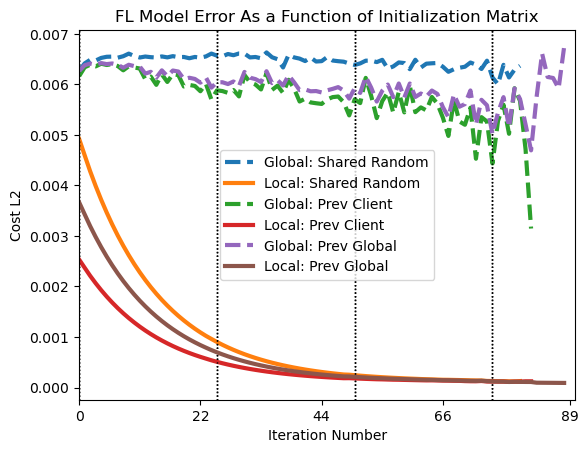

In [23]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, custom_title='FL Model Error As a Function of Initialization Matrix')

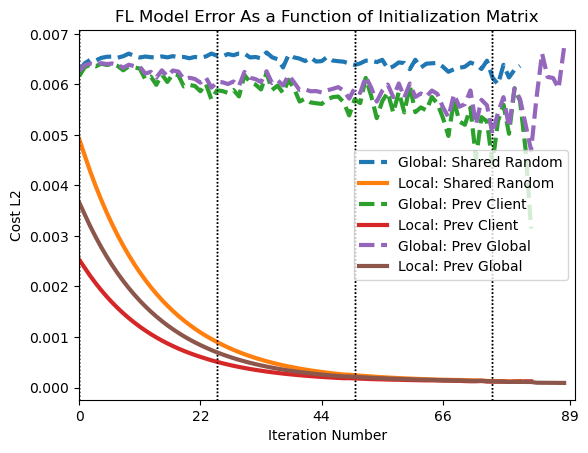

In [24]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, my_legend_loc='center right', custom_title='FL Model Error As a Function of Initialization Matrix')

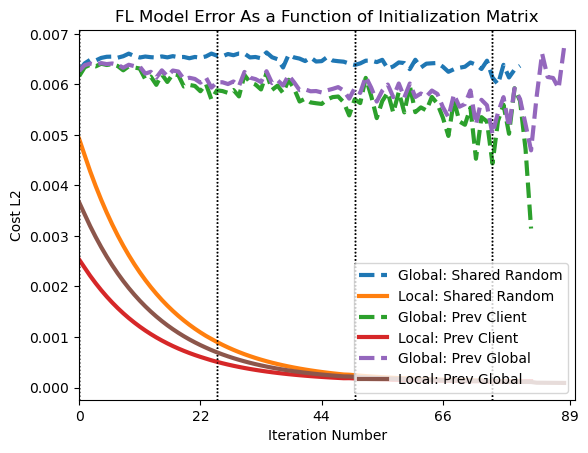

In [25]:
all_users, all_dfs, all_vecs = central_tendency_plotting([user_c0_1ScipyStep, user_c0_1ScipyStep_wclient_init, user_c0_1ScipyStep_wglobalx2_init], iterable_labels=['Global: Shared Random', 'Local: Shared Random', 'Global: Prev Client', 'Local: Prev Client', 'Global: Prev Global', 'Local: Prev Global'], input_linewidth=3, local_error=True, global_error=True, my_legend_loc='lower right', custom_title='FL Model Error As a Function of Initialization Matrix')